**1. Import Library**

In [ ]:
%pip install boruta
%pip install imblearn
%pip install shap
%pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import gc
import optuna

from imblearn.over_sampling import SMOTE
from collections import Counter
from boruta import BorutaPy

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Pre-Processing Data**


*   Load Data




In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/merged_dataset_saya_setelah_rename.csv')

* Inspeksi awal

In [ ]:
df.shape
print("Jumlah baris dan kolom:", df.shape)

Jumlah baris dan kolom: (827658, 41)


In [ ]:
df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.000000,0.00,0.0,...,84,578,563.26,84.239991,563.26,0.000251,100,7.096376e+03,Mirai,Mirai_Greip_Flood
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.000000,0.00,0.0,...,98,578,573.20,48.000000,573.20,0.000195,100,2.304000e+03,Mirai,Mirai_Greip_Flood
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.000000,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000363,100,0.000000e+00,Mirai,Mirai_Greip_Flood
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.000000,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000074,100,0.000000e+00,Mirai,Mirai_Greip_Flood
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.000000,0.01,0.0,...,74,590,563.09,75.596763,563.09,0.000408,100,5.714871e+03,Mirai,Mirai_Greip_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827653,32.00,6,208.00,1437.192982,0.0,0.00,0.0,0.600000,1.00,0.0,...,66,2922,1550.90,870.699393,1550.90,0.000696,10,7.581174e+05,Web Based,Browser_Hijacking
827654,32.00,6,154.00,1047.031628,0.0,0.00,0.0,0.500000,1.00,0.0,...,66,2922,1494.00,1505.244166,1494.00,0.000955,10,2.265760e+06,Web Based,Browser_Hijacking
827655,32.00,6,244.00,1541.116990,0.0,0.00,0.0,0.800000,1.00,0.0,...,1494,2922,2636.40,602.097666,2636.40,0.000821,10,3.625216e+05,Web Based,Browser_Hijacking
827656,32.00,6,244.00,5066.196401,0.0,0.00,0.0,0.600000,1.00,0.0,...,1494,4350,2564.10,1224.308825,2564.10,0.000198,10,1.498932e+06,Web Based,Browser_Hijacking


In [ ]:
df.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.0,0.00,0.0,...,84,578,563.26,84.239991,563.26,0.000251,100,7096.376162,Mirai,Mirai_Greip_Flood
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.0,0.00,0.0,...,98,578,573.20,48.000000,573.20,0.000195,100,2304.000000,Mirai,Mirai_Greip_Flood
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000363,100,0.000000,Mirai,Mirai_Greip_Flood
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000074,100,0.000000,Mirai,Mirai_Greip_Flood
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.0,0.01,0.0,...,74,590,563.09,75.596763,563.09,0.000408,100,5714.870606,Mirai,Mirai_Greip_Flood


In [ ]:
df.tail()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
827653,32.0,6,208.0,1437.192982,0.0,0.0,0.0,0.600000,1.0,0.0,...,66,2922,1550.9,870.699393,1550.9,0.000696,10,7.581174e+05,Web Based,Browser_Hijacking
827654,32.0,6,154.0,1047.031628,0.0,0.0,0.0,0.500000,1.0,0.0,...,66,2922,1494.0,1505.244166,1494.0,0.000955,10,2.265760e+06,Web Based,Browser_Hijacking
827655,32.0,6,244.0,1541.116990,0.0,0.0,0.0,0.800000,1.0,0.0,...,1494,2922,2636.4,602.097666,2636.4,0.000821,10,3.625216e+05,Web Based,Browser_Hijacking
827656,32.0,6,244.0,5066.196401,0.0,0.0,0.0,0.600000,1.0,0.0,...,1494,4350,2564.1,1224.308825,2564.1,0.000198,10,1.498932e+06,Web Based,Browser_Hijacking
827657,32.0,6,244.0,5406.026146,0.0,0.0,0.0,0.571429,1.0,0.0,...,1494,4350,2718.0,1284.822167,2718.0,0.000232,7,1.650768e+06,Web Based,Browser_Hijacking


In [ ]:
df.columns

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'category',
       'label'],
      dtype='object')

**3. Data Cleaning**

* Cek missing/null values (apakah ada nilai kosong)


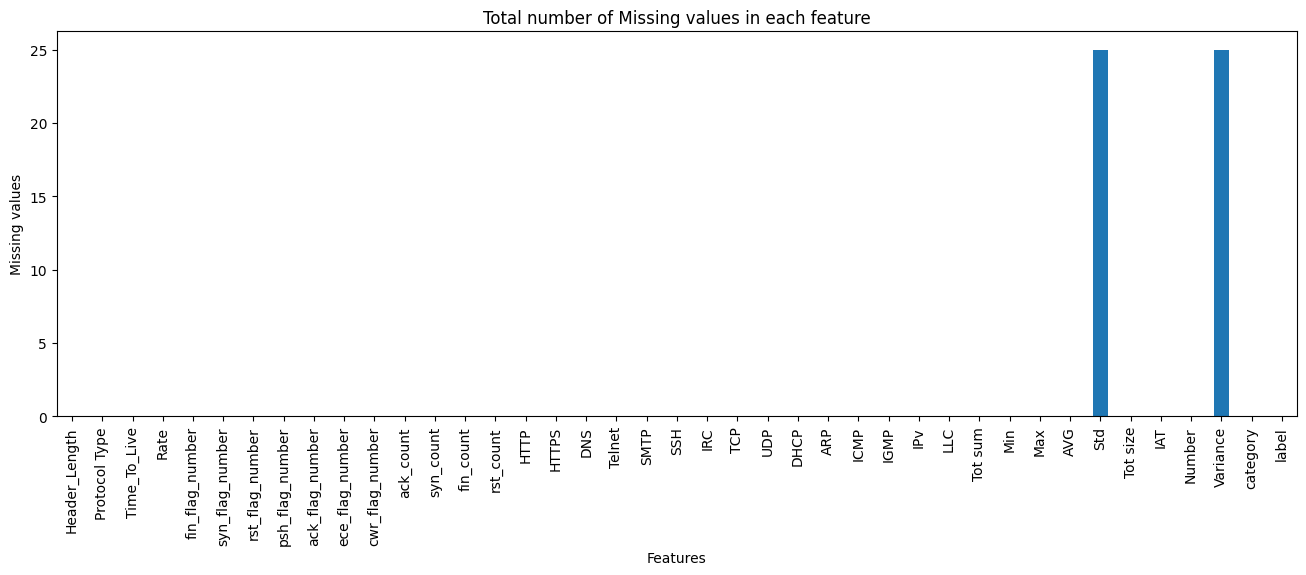

In [ ]:
def plotMissingValues(dataframe):
    missing_values = dataframe.isnull().sum()  # Counting null values for each column
    fig = plt.figure(figsize=(16, 5))
    missing_values.plot(kind='bar')
    plt.xlabel("Features")
    plt.ylabel("Missing values")
    plt.title("Total number of Missing values in each feature")
    plt.show()

plotMissingValues(df)


In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # hanya tampilkan kolom yang ada null-nya

Std         25
Variance    25
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827658 entries, 0 to 827657
Data columns (total 41 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    827658 non-null  float64
 1   Protocol Type    827658 non-null  int64  
 2   Time_To_Live     827658 non-null  float64
 3   Rate             827658 non-null  float64
 4   fin_flag_number  827658 non-null  float64
 5   syn_flag_number  827658 non-null  float64
 6   rst_flag_number  827658 non-null  float64
 7   psh_flag_number  827658 non-null  float64
 8   ack_flag_number  827658 non-null  float64
 9   ece_flag_number  827658 non-null  float64
 10  cwr_flag_number  827658 non-null  float64
 11  ack_count        827658 non-null  int64  
 12  syn_count        827658 non-null  int64  
 13  fin_count        827658 non-null  int64  
 14  rst_count        827658 non-null  int64  
 15  HTTP             827658 non-null  float64
 16  HTTPS            827658 non-null  floa

In [ ]:
df = df.dropna() #Hapus 25 baris

* Cek Duplicate Value

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")

Jumlah baris duplikat: 83381


In [ ]:
df[df.duplicated()].head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
3534,0.0,47,64.0,10952.901238,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000091,100,0.0,Mirai,Mirai_Greip_Flood
4133,0.0,47,64.0,9342.266572,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000107,100,0.0,Mirai,Mirai_Greip_Flood
7726,0.0,47,64.0,11007.227398,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000091,100,0.0,Mirai,Mirai_Greip_Flood
8149,0.0,47,64.0,5049.241585,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000198,100,0.0,Mirai,Mirai_Greip_Flood
8568,0.0,47,64.0,4948.797697,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000202,100,0.0,Mirai,Mirai_Greip_Flood


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (744252, 41)


In [ ]:
df[df.duplicated()].head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label


* Label Encoding

In [ ]:
le = LabelEncoder() #Inisialisasi encoder

In [ ]:
df['Label_encoded'] = le.fit_transform(df['label']) #Fit dan transform label

**4. Exploratory Data Analysis (EDA)**

In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label -> Angka:")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

Mapping Label -> Angka:
Backdoor_Malware -> 0
Benign_Traffic -> 1
Browser_Hijacking -> 2
Command_Injection -> 3
DDoS_ACK_Fragmentation -> 4
DDoS_HTTP_Flood -> 5
DDoS_ICMP_Flood -> 6
DDoS_ICMP_Fragmentation -> 7
DDoS_PSHACK_Flood -> 8
DDoS_RSTFIN_Flood -> 9
DDoS_SYN_Flood -> 10
DDoS_SlowLoris -> 11
DDoS_SynonymousIP_Flood -> 12
DDoS_TCP_Flood -> 13
DDoS_UDP_Flood -> 14
DDoS_UDP_Fragmentation -> 15
DNS_Spoofing -> 16
Dictionary_Brute_Force -> 17
DoS_HTTP_Flood -> 18
DoS_SYN_Flood -> 19
DoS_TCP_Flood -> 20
DoS_UDP_Flood -> 21
MITM_Arp_Spoofing -> 22
Mirai_Greeth_Flood -> 23
Mirai_Greip_Flood -> 24
Mirai_UDPPlain -> 25
Recon_Host_Discovery -> 26
Recon_OSScan -> 27
Recon_Ping_Sweep -> 28
Recon_Port_Scan -> 29
Recon_Vulnerability_Scan -> 30
SQL_Injection -> 31
Uploading_Attack -> 32
XSS -> 33


In [ ]:
# Jumlah tiap kelas berdasarkan nama serangan
print("\nDistribusi kelas (jumlah per label):")
print(df['label'].value_counts())


Distribusi kelas (jumlah per label):
label
Benign_Traffic              33987
Recon_Vulnerability_Scan    33958
Recon_Host_Discovery        33854
Mirai_Greeth_Flood          33708
Recon_OSScan                33591
Recon_Port_Scan             33429
DNS_Spoofing                33335
DoS_HTTP_Flood              30869
MITM_Arp_Spoofing           30455
DoS_SYN_Flood               30332
DDoS_HTTP_Flood             28790
DDoS_SYN_Flood              28149
DoS_UDP_Flood               28069
DDoS_PSHACK_Flood           26811
DDoS_ICMP_Flood             26331
DDoS_TCP_Flood              25169
DoS_TCP_Flood               24876
DDoS_SynonymousIP_Flood     24864
DDoS_UDP_Flood              24620
DDoS_RSTFIN_Flood           23686
DDoS_SlowLoris              23425
DDoS_UDP_Fragmentation      23112
DDoS_ACK_Fragmentation      21939
DDoS_ICMP_Fragmentation     19858
Mirai_UDPPlain              15001
Dictionary_Brute_Force      13062
Mirai_Greip_Flood           11977
Browser_Hijacking            5788
Comm

In [ ]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
Header_Length,744252.0,18.539234,10.670905,0.000000,8.320000,20.000000,26.400000,60.0
Protocol Type,744252.0,10.112967,10.446271,0.000000,6.000000,6.000000,6.000000,47.0
Time_To_Live,744252.0,76.985511,30.990196,0.000000,64.000000,64.000000,73.900000,255.0
Rate,744252.0,inf,NaN,0.000021,339.018788,3213.619734,17098.845285,inf
fin_flag_number,744252.0,0.045471,0.179117,0.000000,0.000000,0.000000,0.000000,1.0
syn_flag_number,744252.0,0.173577,0.334824,0.000000,0.000000,0.000000,0.100000,1.0
rst_flag_number,744252.0,0.073260,0.222763,0.000000,0.000000,0.000000,0.000000,1.0
psh_flag_number,744252.0,0.122746,0.224049,0.000000,0.000000,0.000000,0.200000,1.0
ack_flag_number,744252.0,0.378920,0.405755,0.000000,0.000000,0.200000,0.800000,1.0
ece_flag_number,744252.0,0.000203,0.005646,0.000000,0.000000,0.000000,0.000000,1.0


* Visualisasi Distribusi Label Sebelum SMOTE

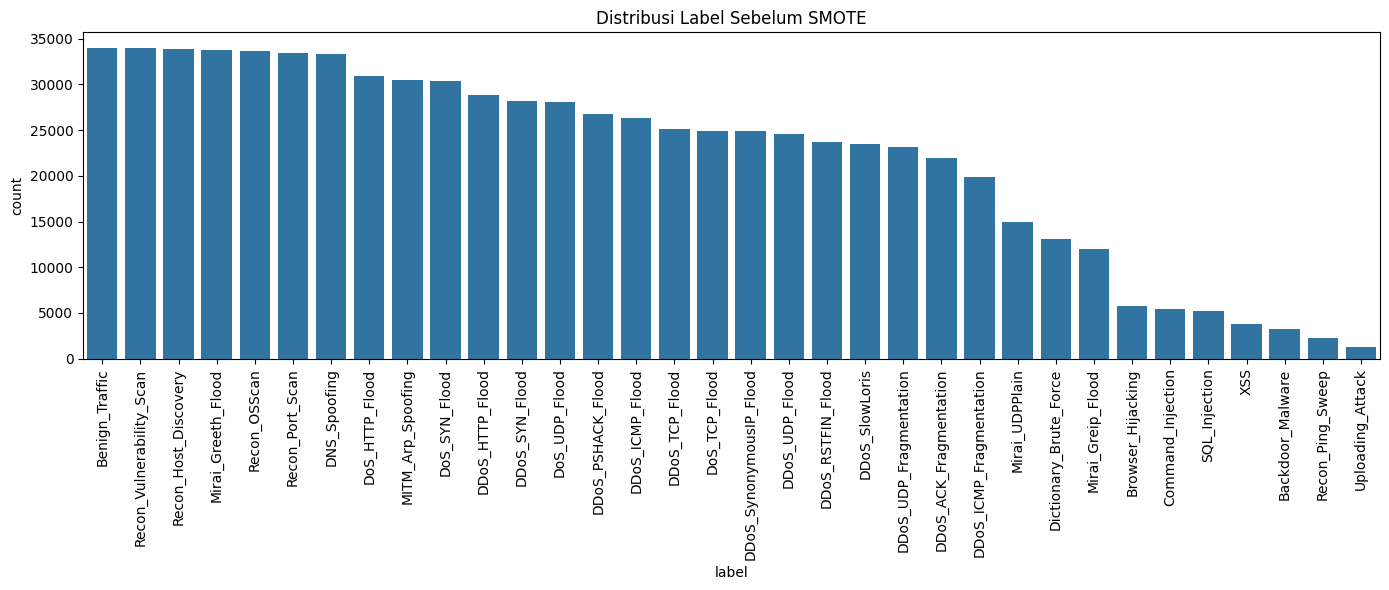

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribusi Label Sebelum SMOTE")
plt.tight_layout()
plt.show()

* Korelasi Fitur Terhadap Label Encoded

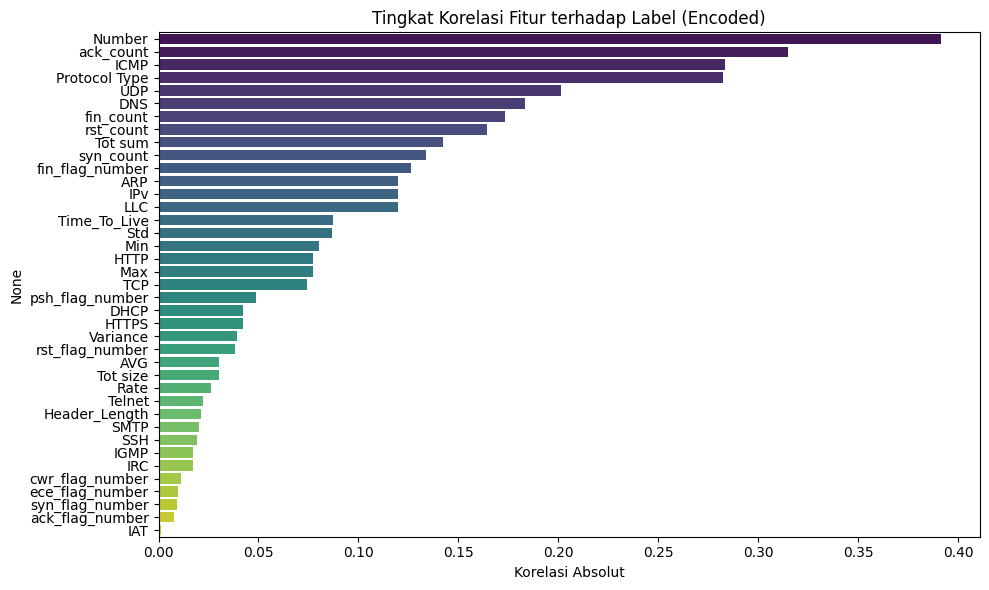

In [ ]:
corr = df.corr(numeric_only=True)
top_corr = corr['Label_encoded'].abs().sort_values(ascending=False).drop('Label_encoded').head(39)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, dodge=False, palette='viridis', legend=False)
plt.title("Tingkat Korelasi Fitur terhadap Label (Encoded)")
plt.xlabel("Korelasi Absolut")
plt.tight_layout()
plt.show()

**5. SMOTE (Synthetic Minority Over-sampling Technique)**

* Penanganan Data Tidak Seimbang/Imbalance Data dengan SMOTE

In [ ]:
smote = SMOTE(random_state=42) #Inisialisasi SMOTE

In [ ]:
# Define X and y by dropping and selecting columns from df
X = df.drop(columns=['category', 'label', 'Label_encoded'])
y = df['Label_encoded']

In [ ]:
# Handle infinite values by replacing them with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that contain NaN values after replacing infinite values
X.dropna(inplace=True)

# Ensure y remains synchronized with the rows dropped from X
y = y[X.index]

print("Infinite values replaced and rows with NaN dropped.")
print("New X shape:", X.shape)
print("New y shape:", y.shape)

Infinite values replaced and rows with NaN dropped.
New X shape: (744247, 39)
New y shape: (744247,)


In [ ]:
print("Ada NaN lagi di X?", X.isnull().sum().sum())
print("Ada inf lagi di X?", X.isin([np.inf, -np.inf]).sum().sum())

Ada NaN lagi di X? 0
Ada inf lagi di X? 0


In [ ]:
# Menerapkan SMOTE pada X dan y
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Menyimpan hasil SMOTE ke file
joblib.dump(X_resampled, '/content/drive/MyDrive/Dataset/Gabungan_Saya/X_resampled_after_smote.pkl')
joblib.dump(y_resampled, '/content/drive/MyDrive/Dataset/Gabungan_Saya/y_resampled_after_smote.pkl')
print("Hasil SMOTE (X_resampled dan y_resampled) telah disimpan.")

Hasil SMOTE (X_resampled dan y_resampled) telah disimpan.


Load hasil Smote yang sudah tersimpan di google drive

In [ ]:
X_resampled = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/X_resampled_after_smote.pkl')
y_resampled = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/y_resampled_after_smote.pkl')

* Visualisasi Distribusi Label Setelah SMOTE

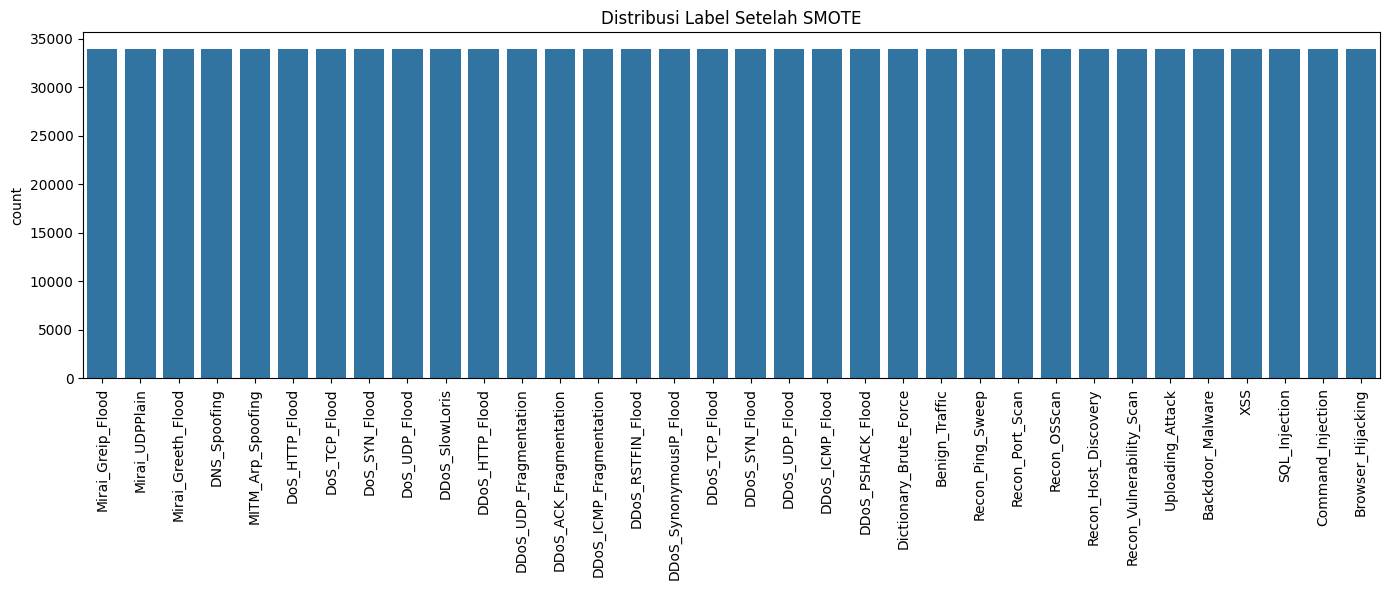

In [ ]:
inverse_mapping = {v: k for k, v in label_mapping.items()} # Mengubah mapping angka ke label Asli
y_resampled_label = [inverse_mapping[i] for i in y_resampled] # Mengubah y_train_resampled ke nama label

plt.figure(figsize=(14, 6))
sns.countplot(x=y_resampled_label, order=pd.Series(y_resampled_label).value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribusi Label Setelah SMOTE')
plt.tight_layout()
plt.show()

* Cek distribusi label setelah SMOTE

In [ ]:
print(df['label'].value_counts()) #sebelum SMOTE
print(pd.Series(y_resampled_label).value_counts()) #sesudah SMOTE

label
Benign_Traffic              33987
Recon_Vulnerability_Scan    33958
Recon_Host_Discovery        33854
Mirai_Greeth_Flood          33708
Recon_OSScan                33591
Recon_Port_Scan             33429
DNS_Spoofing                33335
DoS_HTTP_Flood              30869
MITM_Arp_Spoofing           30455
DoS_SYN_Flood               30332
DDoS_HTTP_Flood             28790
DDoS_SYN_Flood              28149
DoS_UDP_Flood               28069
DDoS_PSHACK_Flood           26811
DDoS_ICMP_Flood             26331
DDoS_TCP_Flood              25169
DoS_TCP_Flood               24876
DDoS_SynonymousIP_Flood     24864
DDoS_UDP_Flood              24620
DDoS_RSTFIN_Flood           23686
DDoS_SlowLoris              23425
DDoS_UDP_Fragmentation      23112
DDoS_ACK_Fragmentation      21939
DDoS_ICMP_Fragmentation     19858
Mirai_UDPPlain              15001
Dictionary_Brute_Force      13062
Mirai_Greip_Flood           11977
Browser_Hijacking            5788
Command_Injection            5388
SQL_Inje

Seleksi Fitur tahap awal

In [ ]:
# Cek fitur dengan 1 nilai unik
constant_columns = [col for col in X_resampled.columns if X_resampled[col].nunique() == 1]
print("Fitur konstan:", constant_columns)

Fitur konstan: []


In [ ]:
# Hapus jika ada dari semua set data
if constant_columns:
    X_resampled.drop(columns=constant_columns, inplace=True)
    print(f"Fitur konstan {constant_columns} dihapus dari X_resampled.")
else:
    print("Tidak ada fitur konstan yang ditemukan.")

Tidak ada fitur konstan yang ditemukan.


In [ ]:
# Hitung korelasi
corr_matrix = X_resampled.corr().abs()

# Ambil korelasi di atas threshold (misal 0.98)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

print("Fitur berkorelasi tinggi:", to_drop)

Fitur berkorelasi tinggi: ['IPv', 'LLC', 'Tot size']


In [ ]:
# Hapus fitur mirip
X_resampled.drop(columns=to_drop, inplace=True)

**6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Akan menampilkan Ukuran data untuk training dan testing
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (924446, 36)
X_test: (231112, 36)
y_train: (924446,)
y_test: (231112,)


**7. Seleksi Fitur Menggunakan Boruta**

* Mengambil Sampel dari X_train untuk Boruta

In [ ]:
X_sampled, y_sampled = resample(
    X_train, y_train,
    n_samples=20000,
    random_state=42,
    stratify=y_train
)

print("Jumlah data yang digunakan Boruta:", X_sampled.shape)

Jumlah data yang digunakan Boruta: (20000, 36)


In [ ]:
# Inisialisasi model Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

In [ ]:
# Inisialisasi Boruta
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', random_state=42)

In [ ]:
# Jalankan Boruta
boruta_selector.fit(X_sampled.values, y_sampled)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=70, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7B0E79679140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B0E79679140)

In [ ]:
# daftar nama fitur yang dipilih:
selected_features = X_sampled.columns[boruta_selector.support_].tolist()

In [ ]:
# Setelah Boruta selesai, simpan objek boruta_selector:
joblib.dump(boruta_selector, '/content/drive/MyDrive/Dataset/Gabungan_Saya/boruta_selected_features.pkl')

# Menyimpan daftar fitur terpilih:
joblib.dump(selected_features, '/content/drive/MyDrive/Dataset/Gabungan_Saya/selected_features.pkl')

print("Boruta feature selection completed.")
print("Daftar fitur terpilih telah disimpan.")

Boruta feature selection completed.
Daftar fitur terpilih telah disimpan.


Load Data Hasil Boruta

In [ ]:
# Load daftar fitur yang dipilih oleh Boruta
selected_features = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/boruta_selected_features.pkl')


# Load hasil boruta dan fitur terpilih
boruta_selector = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/boruta_selected_features.pkl')
selected_features = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/selected_features.pkl')


print("Model Boruta dan fitur terpilih berhasil di-load kembali.")
print("Fitur terpilih oleh boruta:", selected_features)


Model Boruta dan fitur terpilih berhasil di-load kembali.
Fitur terpilih oleh boruta: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'HTTP', 'HTTPS', 'TCP', 'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


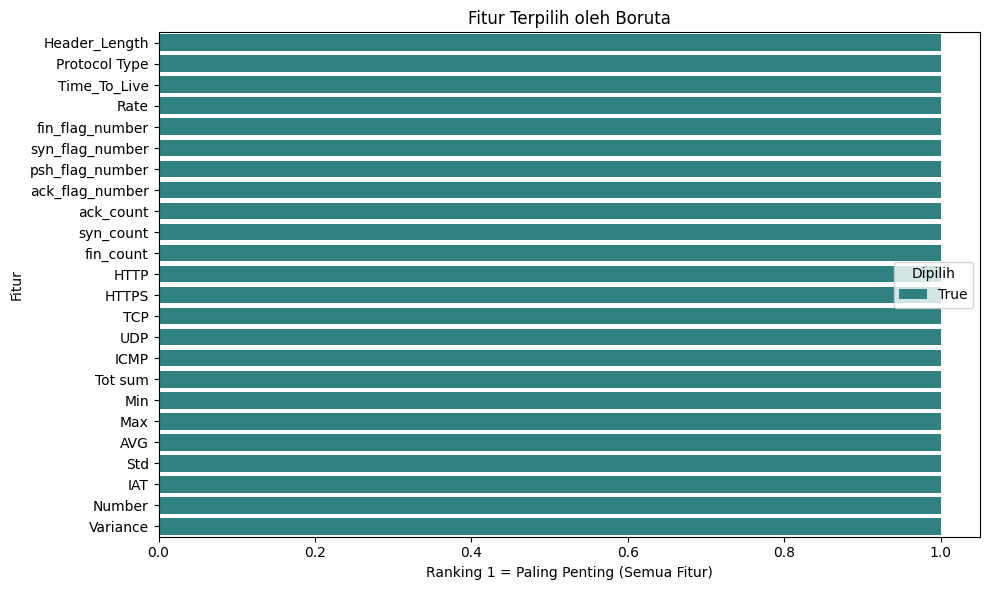

In [ ]:
# Untuk Membuat DataFrame fitur + ranking
ranking = boruta_selector.ranking_
feature_names = X_sampled.columns
support = boruta_selector.support_

# Untuk Membuat dataframe
boruta_result_df = pd.DataFrame({
    'Fitur': feature_names,
    'Ranking': ranking,
    'Dipilih': support
})

# Filter hanya fitur yang dipilih Boruta
selected_df = boruta_result_df[boruta_result_df['Dipilih'] == True]

# Urutkan berdasarkan ranking (Semua yang dipilih = 1)
selected_df = selected_df.sort_values(by='Ranking')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Fitur',
    x='Ranking',
    data=selected_df,
    hue='Dipilih',
    palette='viridis_r',
    dodge=False
)
plt.title("Fitur Terpilih oleh Boruta")
plt.xlabel("Ranking 1 = Paling Penting (Semua Fitur)")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

 fitur-fitur yang ditolak Boruta:

In [ ]:
boruta_result_df[boruta_result_df['Dipilih'] == False].sort_values(by='Ranking')

,Fitur,Ranking,Dipilih
14,rst_count,2,False
6,rst_flag_number,3,False
20,SSH,4,False
25,ARP,5,False
17,DNS,6,False
24,DHCP,7,False
27,IGMP,8,False
21,IRC,9,False
9,ece_flag_number,10,False
10,cwr_flag_number,11,False


In [ ]:
# Identify the features that were not selected by Boruta
rejected_features = [col for col in X_sampled.columns if col not in selected_features]

print("Fitur yang Ditolak oleh Boruta:")
for feature in rejected_features:
    print(feature)

Fitur yang Ditolak oleh Boruta:
rst_flag_number
ece_flag_number
cwr_flag_number
rst_count
DNS
Telnet
SMTP
SSH
IRC
DHCP
ARP
IGMP


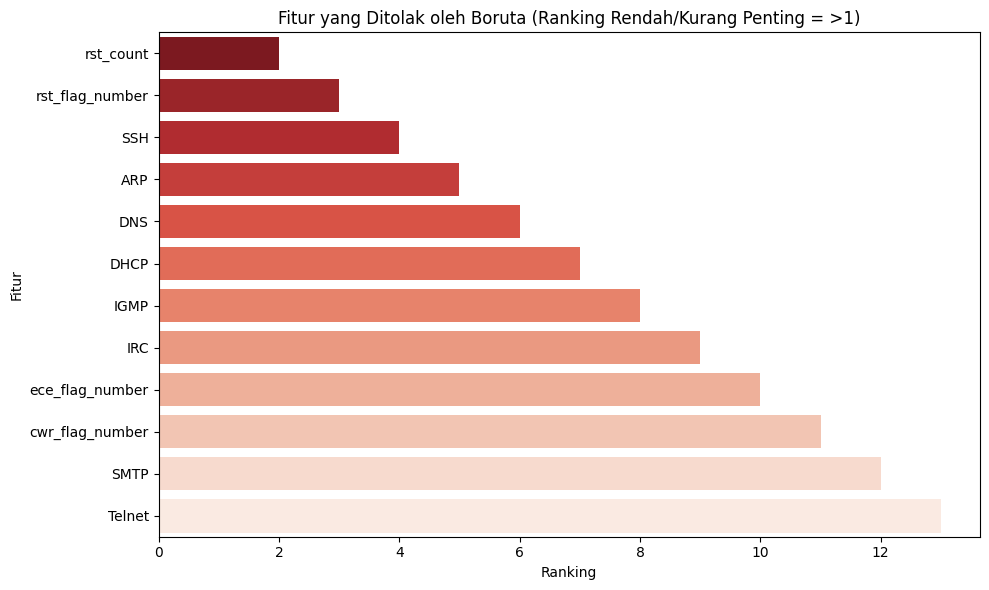

In [ ]:
# Buat DataFrame semua fitur dari Boruta
boruta_result_df = pd.DataFrame({
    'Fitur': X_sampled.columns,
    'Ranking': boruta_selector.ranking_,
    'Dipilih': boruta_selector.support_
})

# Filter fitur yang DITOLAK Boruta
rejected_df = boruta_result_df[boruta_result_df['Dipilih'] == False]
rejected_df = rejected_df.sort_values(by='Ranking', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    y='Fitur',
    x='Ranking',
    data=rejected_df,
    hue='Fitur',
    palette='Reds_r',
    dodge=False,
    legend=False
)
plt.title("Fitur yang Ditolak oleh Boruta (Ranking Rendah/Kurang Penting = >1)")
plt.xlabel("Ranking")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

In [ ]:
# DataFrame lengkap: semua fitur + ranking + status
boruta_result_df = pd.DataFrame({
    'Fitur': X_sampled.columns,
    'Ranking': boruta_selector.ranking_,
    'Status': ['Dipilih ' if s else 'Ditolak ' for s in boruta_selector.support_]
})

# Urutkan berdasarkan ranking (semakin penting = atas)
boruta_result_df = boruta_result_df.sort_values(by='Ranking')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    y='Fitur', x='Ranking',
    hue='Status',
    data=boruta_result_df,
    dodge=False,
    palette={'Dipilih ': 'mediumseagreen', 'Ditolak ': 'lightcoral'}
)
plt.title("Ranking Semua Fitur Berdasarkan Seleksi Boruta")
plt.xlabel("Ranking (1 = Paling Penting)")
plt.ylabel("Fitur")
plt.legend(title='Status Fitur')
plt.tight_layout()
plt.show()

**8. Training Model**

In [ ]:
# Ambil hanya fitur terpilih oleh Boruta
X_train_selected = X_train[selected_features]
X_test_selected  = X_test[selected_features]

# Juga ambil label yang sesuai dengan data yang sudah dipilih fiturnya
y_train_selected = y_train
y_test_selected = y_test


print("Ukuran X_train_selected:", X_train_selected.shape)
print("Ukuran X_test_selected:", X_test_selected.shape)
print("Ukuran y_train_selected:", y_train_selected.shape)
print("Ukuran y_test_selected:", y_test_selected.shape)

Ukuran X_train_selected: (693334, 24)
Ukuran X_test_selected: (231112, 24)
Ukuran y_train_selected: (693334,)
Ukuran y_test_selected: (231112,)


In [ ]:
# Random Forest for multi-class classification
rf_model = RandomForestClassifier(n_estimators=75, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [ ]:
# Ambil 50 ribu data pertama
X_train_sampled = X_train_selected[:250000]
y_train_sampled = y_train[:250000]

print("Ukuran X_train_sampled:", X_train_sampled.shape)
print("Ukuran y_train_sampled:", y_train_sampled.shape)

Ukuran X_train_sampled: (250000, 23)
Ukuran y_train_sampled: (250000,)


In [ ]:
# Inisialisasi model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

In [ ]:
# Training dengan data lebih kecil
rf.fit(X_train_sampled, y_train_sampled)
print("Model berhasil dilatih dengan subset data!")

Model berhasil dilatih dengan subset data!


In [ ]:

# Simpan model yang sudah dilatih
joblib.dump(rf, '/content/drive/MyDrive/Dataset/Gabungan_Saya/rfpercobaan1.pkl')

['/content/drive/MyDrive/Dataset/Gabungan_Saya/rfpercobaan1.pkl']

In [ ]:

# Load model dari file
rf = joblib.load('/content/drive/MyDrive/Dataset/Gabungan_Saya/rfpercobaan1.pkl')

**9. Evaluasi Model**

In [ ]:
# Function to generate and display a detailed confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12)) # Increased figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)  # Rotate x-axis labels
    plt.yticks(rotation=0)   # Keep y-axis labels horizontal
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

In [ ]:
# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, rf_pred)
# For multi-class, f1_score, precision_score, and recall_score require 'average' parameter
rf_f1 = f1_score(y_test, rf_pred, average='weighted') # Use 'weighted' for imbalanced datasets
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')

print('\nRandom Forest Metrics (Weighted Average):')
print(f'Accuracy: {rf_accuracy:.4f}')
print(f'F1 Score: {rf_f1:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')

# Print classification report for detailed per-class metrics
print('\nRandom Forest Classification Report:')
print(classification_report(y_test, rf_pred, target_names=[str(i) for i in rf_model.classes_]))


Random Forest Metrics (Weighted Average):
Accuracy: 0.8355
F1 Score: 0.8346
Precision: 0.8366
Recall: 0.8355

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6797
           1       0.51      0.73      0.60      6797
           2       0.85      0.83      0.84      6797
           3       0.87      0.79      0.83      6798
           4       1.00      0.99      1.00      6797
           5       0.91      0.89      0.90      6797
           6       1.00      1.00      1.00      6798
           7       1.00      1.00      1.00      6798
           8       1.00      1.00      1.00      6797
           9       1.00      1.00      1.00      6797
          10       0.47      0.46      0.46      6798
          11       0.95      0.99      0.97      6797
          12       0.50      0.54      0.52      6797
          13       1.00      1.00      1.00      6797
          14       1.00      1.00      1.

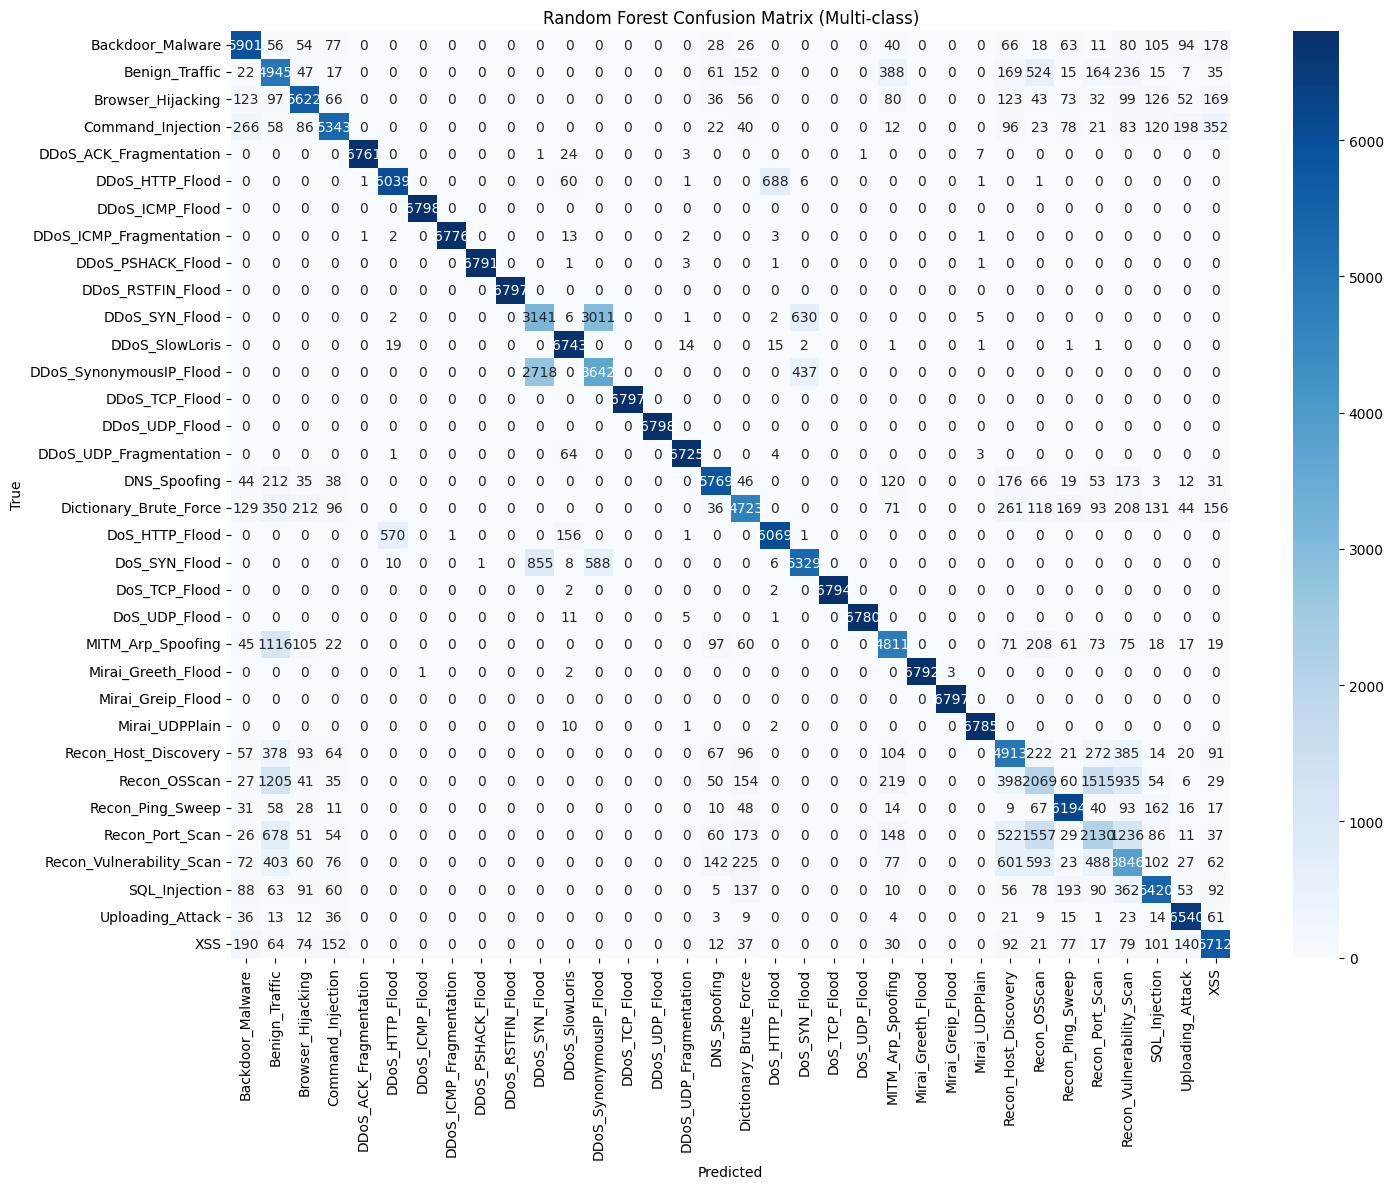

In [ ]:
# Get the class names from the label_map for plotting the confusion matrix
class_names = [label for label, i in sorted(label_mapping.items(), key=lambda item: item[1])]

# Confusion Matrix for Random Forest (Multi-class)
plot_confusion_matrix(y_test, rf_pred, class_names, 'Random Forest Confusion Matrix (Multi-class)')

In [ ]:
# Getting feature importances from the trained model
importances = rf_model.feature_importances_

# Getting the indices of features sorted by importance
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
feature_names = [X_train.columns[i] for i in indices]  # Use actual column names

# Plotting feature importances horizontally
plt.figure(figsize=(8, 14))
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), feature_names)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

Bayesian Optimization

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    model = RandomForestClassifier(random_state=42, **params)
    # Use X_train_optuna and y_train_optuna for training, X_val_optuna and y_val_optuna for evaluation
    model.fit(X_train_optuna, y_train_optuna)
    val_preds = model.predict(X_val_optuna)
    accuracy = accuracy_score(y_val_optuna, val_preds)
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)

[I 2025-09-11 10:07:42,682] A new study created in memory with name: no-name-4fcf17ef-4a77-43c0-bd9a-54865267194e
[I 2025-09-11 11:04:20,221] Trial 0 finished with value: 0.7171068572813182 and parameters: {'n_estimators': 700, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7171068572813182.
[I 2025-09-11 11:13:06,065] Trial 1 finished with value: 0.6457431894492713 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7171068572813182.
[I 2025-09-11 11:46:52,773] Trial 2 finished with value: 0.6657767662432068 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7171068572813182.
[I 2025-09-11 12:12:57,898] Trial 3 finished with value: 0.6904531136418706 and parameters: {'n_estimators': 400, 'max_depth': 10, '

In [ ]:
# Split the training data further into training and validation sets using selected features
# Ensure y_train_selected corresponds to the rows in X_train_selected
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(
    X_train_selected, y_train_selected, # Use X_train_selected and y_train_selected
    test_size=0.25, # Using 25% of the original training data for validation (which is 20% of the total data)
    random_state=42,
    stratify=y_train_selected
)

print("X_train_optuna shape after splitting for validation:", X_train_optuna.shape)
print("X_val_optuna shape:", X_val_optuna.shape)
print("y_train_optuna shape after splitting for validation:", y_train_optuna.shape)
print("y_val_optuna shape:", y_val_optuna.shape)

X_train_optuna shape after splitting for validation: (520000, 24)
X_val_optuna shape: (173334, 24)
y_train_optuna shape after splitting for validation: (520000,)
y_val_optuna shape: (173334,)


In [ ]:
import time

start_time = time.time()

study = optuna.create_study(direction='maximize')
# Use the objective function that now uses X_train_optuna, y_train_optuna, X_val_optuna, and y_val_optuna
study.optimize(objective, n_trials=20)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)

end_time = time.time()
exec_time = end_time - start_time
print(f"Waktu eksekusi Optuna: {exec_time:.2f} detik")

[I 2025-09-23 18:32:53,205] A new study created in memory with name: no-name-a04449c9-5fc7-4dd5-bbb3-83fdd260199a
[I 2025-09-23 19:00:20,503] Trial 0 finished with value: 0.7012588413121488 and parameters: {'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7012588413121488.
[I 2025-09-23 19:16:28,094] Trial 1 finished with value: 0.6060438229083734 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7012588413121488.
[I 2025-09-23 19:40:26,079] Trial 2 finished with value: 0.6925242595220787 and parameters: {'n_estimators': 600, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7012588413121488.
[I 2025-09-23 20:12:39,558] Trial 3 finished with value: 0.68355890938881 and parameters: {'n_estimators': 900, 'max_depth': 10, 'mi

Number of finished trials: 20
Best trial: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}
Best accuracy: 0.7278375852400568
Waktu eksekusi Optuna: 21192.58 detik
